In [1]:
!pip install scattertext
!pip install wordcloud
!pip install git+https://github.com/lambdaofgod/mlutil
!pip install scattertext
!pip install spacy

  Cloning https://github.com/lambdaofgod/mlutil to /tmp/pip-req-build-fencjexd
  Running command git clone -q https://github.com/lambdaofgod/mlutil /tmp/pip-req-build-fencjexd
  Stored in directory: /tmp/pip-ephem-wheel-cache-zz_wnfjp/wheels/42/32/46/9616d5dd85e5dbc05ce3816dfa7dcedc052bc8b29442e1766a
Successfully built mlutil


In [2]:
import tqdm
import requests
from mlutil import topic_modeling

from sklearn import decomposition, feature_extraction
from sklearn.feature_extraction import stop_words
from sklearn import pipeline
 
from pandas.io.json import json_normalize

import scattertext

import seaborn as sns
import wordcloud

import matplotlib.pyplot as plt
import spacy

W0717 22:16:52.439847 140444527937408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/mlutil/embeddings.py:87: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
def get_word_cloud(texts):
  text = ' '.join(texts)
  return wordcloud.WordCloud(max_font_size=40).generate(text)


def show_word_cloud(wc, figure_kwargs={'figsize': (8, 5)}):
  plt.figure(**figure_kwargs)
  plt.imshow(wc)
  plt.axis('off')
  plt.show()

  
def show_word_cloud_from_texts(text_column):
  texts = text_column.fillna('').values
  cloud = get_word_cloud(texts)
  show_word_cloud(cloud)

Put your Github token to `github_auth_key.txt`

You have to do this because, unfortunately, for now there is no way to use GraphQL without authentication.

In [0]:
key = open('github_auth_key.txt', 'r').read().strip()

Note that I barely know GraphQL: I made this query in [Github's API explorer](https://developer.github.com/v4/explorer/)

In [0]:
# An example to get the remaining rate limit using the Github GraphQL API.
headers = {'Authorization': 'token ' + key}


def run_query(query): # A simple function to use requests.post to make the API call. Note the json= section.
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

        
# The GraphQL query (with a few aditional bits included) itself defined as a multi-line string.       
def get_next_paged_result(result):
  if result is None:
    end_cursor_string = ''
  else:
    end_cursor_string = 'after: "{}"'.format(result['data']['viewer']['starredRepositories']['pageInfo']['endCursor'])
  new_query_string = """{{
    viewer {{
      starredRepositories(first: 100, {}) {{
        pageInfo {{
          startCursor
          hasNextPage
          endCursor
        }}
        nodes {{
          name
          owner {{
            login
          }}
          description
          primaryLanguage {{
            name
          }}
          repositoryTopics(first: 10) {{
            nodes {{
              topic {{
                name
              }}
            }}
          }}
        }}
      }}
    }}
  }}""".format(end_cursor_string)
  return run_query(new_query_string)

In [0]:
new_query_string = """{{
    viewer {{
      starredRepositories(first: 100, {}) {{
        pageInfo {{
          startCursor
          hasNextPage
          endCursor
        }}
        nodes {{
          name
          owner {{
            login
          }}
          description
          primaryLanguage {{
            name
          }}
          repositoryTopics(first: 10) {{
            nodes {{
              topic {{
                name
              }}
            }}
          }}
        }}
      }}
    }}
  }}"""

In [21]:
print(new_query_string.format(''))

{
    viewer {
      starredRepositories(first: 100, ) {
        pageInfo {
          startCursor
          hasNextPage
          endCursor
        }
        nodes {
          name
          owner {
            login
          }
          description
          primaryLanguage {
            name
          }
          repositoryTopics(first: 10) {
            nodes {
              topic {
                name
              }
            }
          }
        }
      }
    }
  }


In [6]:
next_result = None
starred_repo_information = []
for __ in tqdm.tqdm(range(5)):
  next_result = get_next_paged_result(next_result)
  starred_repo_information = starred_repo_information + next_result['data']['viewer']['starredRepositories']['nodes']

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


In [0]:
def get_cleaned_starred_repositories_df(starred_repo_information):
  starred_repo_df = json_normalize(starred_repo_information)
  starred_repo_df.index = starred_repo_df['name']
  starred_repo_df.drop('name', axis=1, inplace=True)
  starred_repo_df['primaryLanguage'] = starred_repo_df['primaryLanguage.name']
  starred_repo_df.drop('primaryLanguage.name', axis=1)
  starred_repo_df['topics'] = starred_repo_df['repositoryTopics.nodes'].apply(lambda recs: [r['topic']['name'] for r in recs])
  starred_repo_df['description'].fillna('', inplace=True)
  return starred_repo_df

In [0]:
starred_repo_df = get_cleaned_starred_repositories_df(starred_repo_information)

Primary language

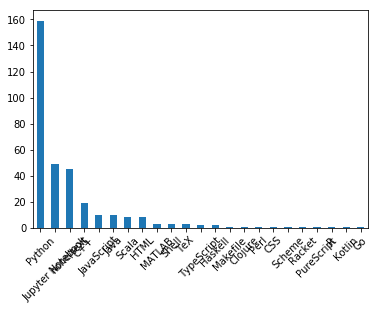

In [9]:
starred_repo_df['primaryLanguage'].fillna('none/text').value_counts().plot.bar(rot=45);

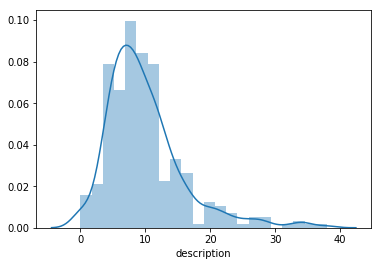

In [10]:
sns.distplot(starred_repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l)));

Topics word cloud

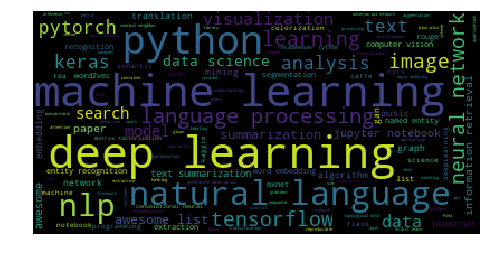

In [11]:
show_word_cloud_from_texts(starred_repo_df['topics'].apply(' '.join))

Descriptions word cloud

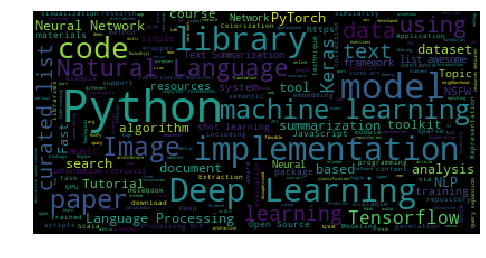

In [12]:
show_word_cloud_from_texts(starred_repo_df['description'])

## Topic modeling (repo descriptions)

In [0]:
nmf = decomposition.NMF(n_components=10)

In [0]:
vectorizer = feature_extraction.text.TfidfVectorizer(stop_words=stop_words.ENGLISH_STOP_WORDS)
description_vectors = vectorizer.fit_transform(starred_repo_df['description'])

In [0]:
reduced_description_vectors = nmf.fit_transform(description_vectors)

In [0]:
topic_words = topic_modeling.top_topic_words(nmf, vectorizer.get_feature_names(), 10)

In [17]:
topic_words

,0,1,2,3,4,5,6,7,8,9
topic_0,learning,deep,machine,pytorch,models,materials,cookbox,hash,projects,shot
topic_1,language,natural,processing,nlp,course,art,state,tasks,models,resources
topic_2,list,curated,resources,awesome,dedicated,software,frameworks,packages,tutorials,libraries
topic_3,python,implementation,algorithm,wrapper,fast,textrank,rouge,using,framework,nudity
topic_4,summarization,text,extractive,using,bert,abstractive,dataset,keras,sequence,seq2seq
topic_5,image,nsfw,keras,model,neural,tensorflow,detector,colorization,collection,training
topic_6,factorization,machines,library,aware,field,fastfm,python,matrix,nimfa,easy
topic_7,analysis,data,topological,music,tools,notebooks,synthesis,bindings,libraries,dataset
topic_8,code,paper,shot,2017,zero,presented,icml,simple,papers,sparse
topic_9,retrieval,information,library,open,source,research,query,search,based,toolkit
